<a href="https://colab.research.google.com/github/kaushik241/Dogs-and-Cat-Classification/blob/main/Dogs%20and%20Cats%20with%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Notes:
### Have done training till 8 epochs


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml h5py  
# Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"phttps://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   121M      0  0:00:06  0:00:06 --:--:--  117M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      MyDrive	       sample_data
 drive			      PetImages
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [ ]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


## Generate a `Dataset`


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


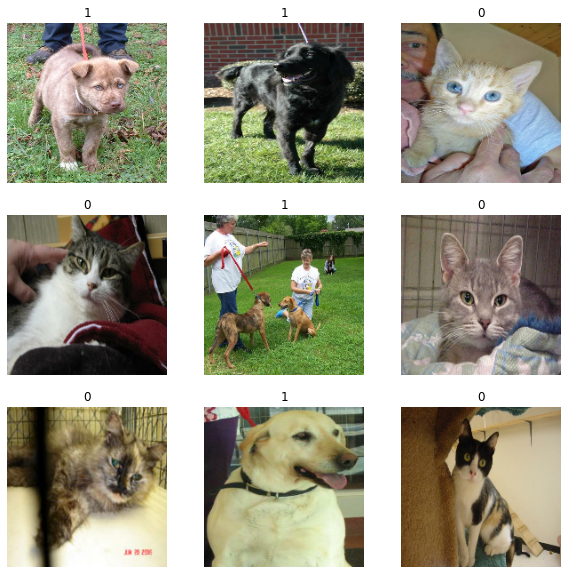

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


Complete the below code for image augmentation 

add layers to flip horizontal and rotation of the image with factor "0.1"

In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import keras 

In [ ]:

data_augmentation = keras.Sequential(
    [
      # add layers here for the augmentation
     layers.RandomFlip("horizontal"),  # For Horizontal Flip
     layers.RandomRotation(factor = 0.1), # For Random Rotation with factor 0.1
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


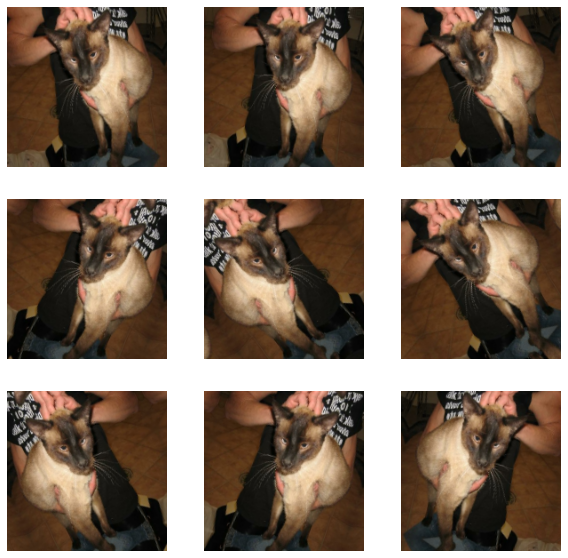

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


Complete the code given below 


you have to add 6 layers in the code below total two set of code 3 lines each starting with convolutional layer with filter size 32 , kernal size 3 with same padding followed by Batchnormalization and relu ac activation function.the second set has filter size 64 folllowed by same 2 layers as stated in thefirst set of layers.

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

    # add your code here
    x = layers.SeparableConv2D(filters=32,kernel_size = (3,3),padding = "same", input_shape = input_shape)(x) #Layer with 32 filters and kernel size (3,3) and applying padding
    x = layers.BatchNormalization()(x) #Doing Batch normalization 
    x = layers.Activation("relu")(x) #Using activation function as relu
    #Haven't used pooling yet

    x = layers.SeparableConv2D(filters=64,kernel_size = (3,3),padding = "same")(x) #Layer with 32 filters and kernel size (3,3) and applying padding
    x = layers.BatchNormalization()(x) #Doing Batch normalization
    x = layers.Activation("relu")(x) #Using activation function as relu
    #Haven't used pooing yet

    

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


## Train the model


Create the model using function make_model and plot it using keras
remember the input image has 3 chanel shape and number of classes are two here

In [ ]:
# code here
model = make_model((180,180,3),2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 separable_conv2d (SeparableCon  (None, 180, 180, 32  155        ['rescaling[0][0]']          

compile the model and train it for 50 epochs with a callback that save the model in ".h5" format remember to use the adam optimizer with learning rate of 1e-3 use appropriate loss function according to binary classification and metrics should be accuracy here

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoints')

NotFoundError: ignored

In [ ]:
# code here
adam = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy']) 

filepath = "/content/drive/MyDrive/checkpoints"
model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True , verbose=1)

history = model.fit(train_ds,epochs=50,verbose=1,callbacks=[model_callback],validation_data=val_ds)
#Stopped Training till 8 epochs becaose it was taking a lot of time to train with 50 epochs

Epoch 1/50
586/586 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.6231
Epoch 1: val_accuracy improved from -inf to 0.62666, saving model to /content/drive/MyDrive/checkpoints
586/586 [==============================] - 701s 1s/step - loss: 0.6671 - accuracy: 0.6231 - val_loss: 0.6329 - val_accuracy: 0.6267
Epoch 2/50
586/586 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7260
Epoch 2: val_accuracy improved from 0.62666 to 0.67386, saving model to /content/drive/MyDrive/checkpoints
586/586 [==============================] - 689s 1s/step - loss: 0.5458 - accuracy: 0.7260 - val_loss: 0.7211 - val_accuracy: 0.6739
Epoch 3/50
586/586 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.7777
Epoch 3: val_accuracy did not improve from 0.67386
586/586 [==============================] - 689s 1s/step - loss: 0.4724 - accuracy: 0.7777 - val_loss: 1.2061 - val_accuracy: 0.5921
Epoch 4/50
586/586 [==============================] - 

KeyboardInterrupt: ignored

In [ ]:
checkpoint_dir = os.path.dirname(filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


1/1 [==============================] - 1s 590ms/step
This image is 83.53 percent cat and 16.47 percent dog.
